In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns 

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.impute import KNNImputer

In [103]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [195]:
train = pd.read_csv('flat_info_train.csv')
test = pd.read_csv('flat_info_test.csv')

In [196]:
train.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,36378153,BCN life - Habitación,96039422,Rogerio,la Sagrera,41.42058,2.18816,Private room,31,0,NaN,NaN,1,365,13
1,26940439,Two Bedroom Apartment next to Sagrada Familia,98330509,Apart-Suites,la Sagrada Família,41.40149,2.17145,Entire home/apt,2,1,2020-10-26,0.28,5,279,141
2,42962582,"Hostal Nitzs BCN, Small Double w/ Shared Bathroom",341323870,Hostal Nitzs BCN,el Barri Gòtic,41.38211,2.17781,Private room,1,28,2020-10-22,3.87,5,365,999
3,36423530,GRAN Apto.Centro BCN. 5HAB. 3 BAÑOS Eixample,36438736,Dessy,l'Antiga Esquerra de l'Eixample,41.38985,2.15507,Entire home/apt,2,10,2020-02-09,0.51,1,225,289
4,23931051,Lucuma - Nice apartment at 7 min. walk of Ramb...,175453328,Amarantha,Sant Gervasi - Galvany,41.39416,2.14736,Entire home/apt,1,1,2018-09-30,0.03,12,332,86


In [197]:
train.shape

(16623, 15)

In [198]:
test.shape

(1848, 14)

In [199]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16623 entries, 0 to 16622
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              16623 non-null  int64  
 1   name                            16614 non-null  object 
 2   host_id                         16623 non-null  int64  
 3   host_name                       16609 non-null  object 
 4   neighbourhood                   16623 non-null  object 
 5   latitude                        16623 non-null  float64
 6   longitude                       16623 non-null  float64
 7   room_type                       16623 non-null  object 
 8   minimum_nights                  16623 non-null  int64  
 9   number_of_reviews               16623 non-null  int64  
 10  last_review                     11404 non-null  object 
 11  reviews_per_month               11404 non-null  float64
 12  calculated_host_listings_count  

In [200]:
train.isnull().sum()

id                                   0
name                                 9
host_id                              0
host_name                           14
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       5219
reviews_per_month                 5219
calculated_host_listings_count       0
availability_365                     0
price                                0
dtype: int64

# task 1.a
Distibution of prices by room types and neighbourhoods

Text(0.5, 1.0, 'Distribution of neighbourhoods')

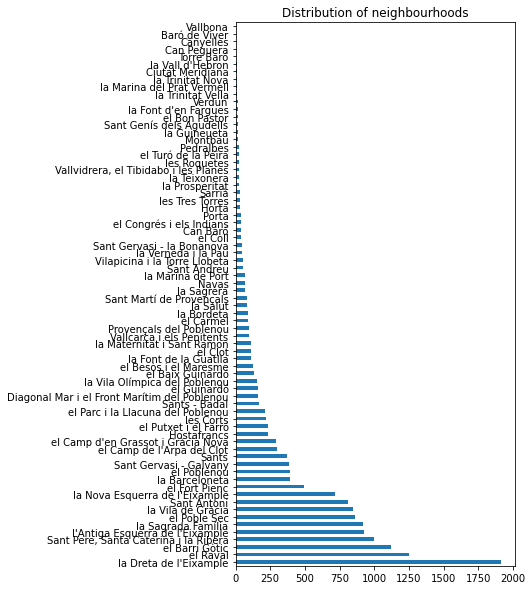

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
train['neighbourhood'].value_counts().plot.barh();
plt.title("Distribution of neighbourhoods")

In [15]:
train['neighbourhood'].value_counts().head(10)

la Dreta de l'Eixample                   1916
el Raval                                 1251
el Barri Gòtic                           1123
Sant Pere, Santa Caterina i la Ribera    1001
l'Antiga Esquerra de l'Eixample           927
la Sagrada Família                        920
el Poble Sec                              858
la Vila de Gràcia                         847
Sant Antoni                               809
la Nova Esquerra de l'Eixample            718
Name: neighbourhood, dtype: int64

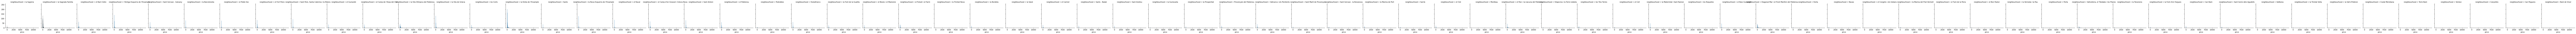

In [83]:
g = sns.FacetGrid(train, col="neighbourhood")
g.map(sns.histplot, "price")

Text(0.5, 1.0, 'Distribution of room types')

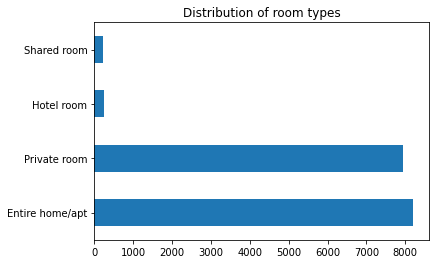

In [52]:
train['room_type'].value_counts().plot.barh();
plt.title("Distribution of room types")

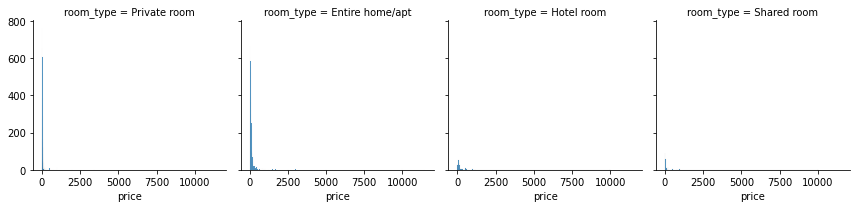

In [82]:
g = sns.FacetGrid(train, col="room_type")
g.map(sns.histplot, "price")

# notes
we see in each category anomaly  
Delete features that doesn't have any logical impact on our price

In [201]:
train = train.drop(['id','name','host_id','host_name'],axis=1)

In [17]:
test_neighbourhoods = list(test.neighbourhood.unique())
train_neighbourhoods = list(train.neighbourhood.unique())
for place in test_neighbourhoods:
    if place not in train_neighbourhoods:
        print(place)

### we see that all places that in test dataset are in train

In [78]:
train1 = pd.read_csv('flat_info_train.csv')


In [202]:
hash_space=3000
train['hashed_places'] = pd.Series(hash(place)%hash_space for place in train.neighbourhood)

In [203]:
train = train.drop('neighbourhood' ,axis=1)

In [204]:
train['hashed_rooms'] = pd.Series(hash(place)%hash_space for place in train.room_type)

In [205]:
train = train.drop('room_type' ,axis=1)

### using hashing trick to neighbourhood categorical feature and for room_type 

In [206]:
from datetime import datetime

now = datetime.now().date()
print(now)

2021-06-22


In [207]:
train.last_review = pd.to_datetime(train.last_review)

In [208]:
new_days=[]
for last in train.last_review:
    try:
        new_days.append((now-last.date()).days)
    except:
        new_days.append(np.nan)

In [209]:
train['days_last_review'] = pd.Series(new_days)

In [210]:
train = train.drop('last_review',axis=1)

In [212]:
train.fillna(0)

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price,hashed_places,hashed_rooms,days_last_review
0,41.42058,2.18816,31,0,0.00,1,365,13,690,382,0.0
1,41.40149,2.17145,2,1,0.28,5,279,141,2704,1660,239.0
2,41.38211,2.17781,1,28,3.87,5,365,999,2536,382,243.0
3,41.38985,2.15507,2,10,0.51,1,225,289,483,1660,499.0
4,41.39416,2.14736,1,1,0.03,12,332,86,1507,1660,996.0
...,...,...,...,...,...,...,...,...,...,...,...
16618,41.38256,2.16736,2,44,2.14,3,161,18,2879,382,470.0
16619,41.37805,2.17758,2,38,1.93,1,0,50,2536,382,281.0
16620,41.39776,2.14171,32,17,0.39,1,348,80,1507,1660,296.0
16621,41.41206,2.17018,3,42,0.51,1,101,50,2084,382,484.0


### create new feature with the same sense -- days from last review

# Task 1.b
Statistics of number_of_reviews, reviews_per_month, days_last_review

In [27]:
train[['number_of_reviews','reviews_per_month','days_last_review']].describe()

,number_of_reviews,reviews_per_month,days_last_review
count,16623.000000,11404.000000,11404.000000
mean,31.809060,0.969043,564.386794
std,63.500847,1.132891,396.695214
min,0.000000,0.010000,132.000000
25%,0.000000,0.150000,304.000000
50%,3.000000,0.520000,479.000000
75%,33.000000,1.450000,634.000000
max,786.000000,15.540000,3293.000000


In [28]:
imputer = KNNImputer(n_neighbors=5)

In [30]:
new_train=imputer.fit_transform(train)

In [32]:
new_train = pd.DataFrame(data=new_train,columns=['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','price','hashed_places','hashed_rooms','days_last_review'])

In [33]:
new_train

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price,hashed_places,hashed_rooms,days_last_review
0,41.42058,2.18816,31.0,0.0,0.206,1.0,365.0,13.0,10.0,62.0,474.7
1,41.40149,2.17145,2.0,1.0,0.280,5.0,279.0,141.0,24.0,60.0,239.0
2,41.38211,2.17781,1.0,28.0,3.870,5.0,365.0,999.0,16.0,62.0,243.0
3,41.38985,2.15507,2.0,10.0,0.510,1.0,225.0,289.0,3.0,60.0,499.0
4,41.39416,2.14736,1.0,1.0,0.030,12.0,332.0,86.0,27.0,60.0,996.0
...,...,...,...,...,...,...,...,...,...,...,...
16618,41.38256,2.16736,2.0,44.0,2.140,3.0,161.0,18.0,79.0,62.0,470.0
16619,41.37805,2.17758,2.0,38.0,1.930,1.0,0.0,50.0,16.0,62.0,281.0
16620,41.39776,2.14171,32.0,17.0,0.390,1.0,348.0,80.0,27.0,60.0,296.0
16621,41.41206,2.17018,3.0,42.0,0.510,1.0,101.0,50.0,4.0,62.0,484.0


### missing values were replaced with Knnimputer 

# Task 1.c
different correlation with prices

<AxesSubplot:>

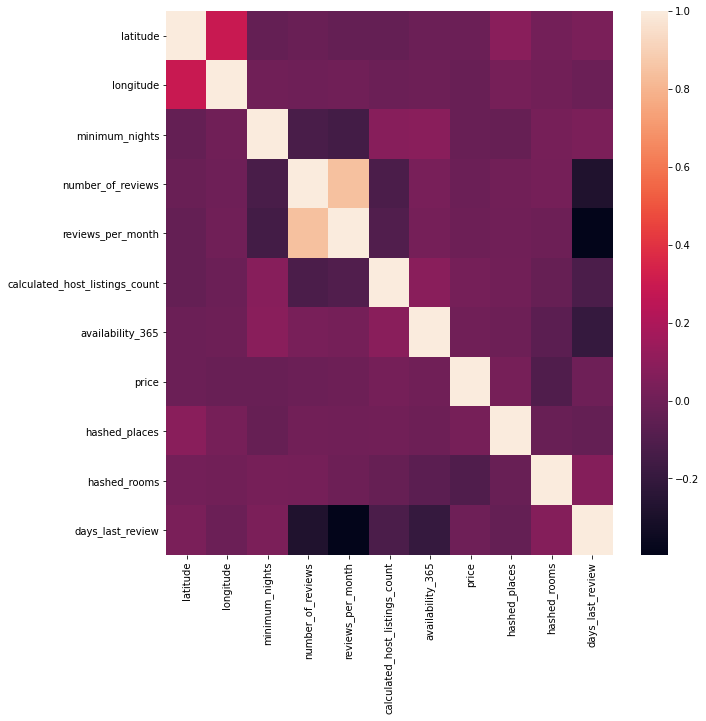

In [35]:
rcParams['figure.figsize'] = 10, 10
sns.heatmap(new_train.corr())

# task 1.d
detect anomalies

<AxesSubplot:xlabel='price', ylabel='Count'>

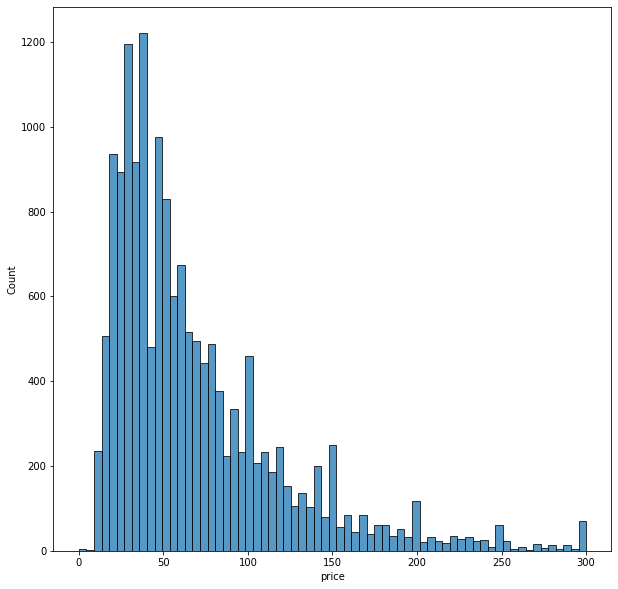

In [40]:
sns.histplot((train.price.loc[train.price<=300]))

In [41]:
train.price.loc[train.price<=300].skew()

1.713364311593887

In [42]:
train.price.loc[train.price<=300].kurt()

3.337601262810789

In [44]:
train.price.loc[train.price<=400].skew()

2.1371358492575596

In [43]:
train.price.loc[train.price<=400].kurt()

5.9080456582720595

### if we take prices lower or equal to 300 than we have something more close to normal distribution 


In [213]:
bad_indexes=list(train.loc[train.price>300].index)

In [94]:
train.drop(bad_indexes).hashed_places.nunique()

72

In [214]:
train = train.drop(bad_indexes)

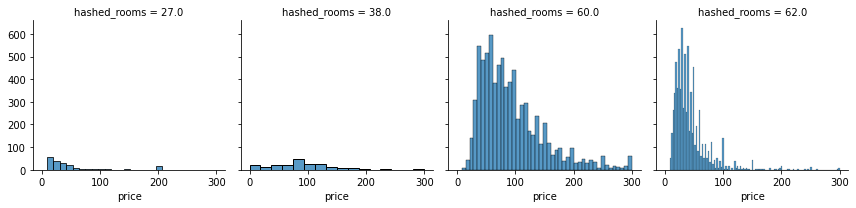

In [100]:
g = sns.FacetGrid(new_train, col="hashed_rooms")
g.map(sns.histplot, "price")

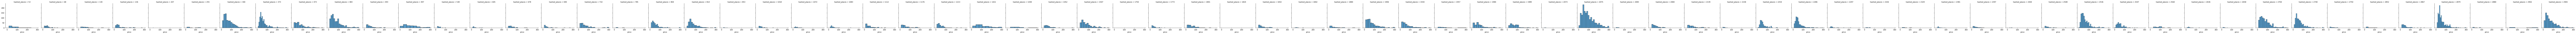

In [102]:
g = sns.FacetGrid(new_train, col="hashed_places")
g.map(sns.histplot, "price")

# task 2.a

In [215]:
X = train.drop('price', axis=1)

y = train['price']

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [217]:
xgb_reg=XGBRegressor()


In [218]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
from sklearn.metrics import mean_squared_error

In [219]:
y_pred = xgb_reg.predict(X_test)


In [114]:
import xgboost as xgb

In [220]:
print('Target matric of base model is : {0:0.4f} '.format(mean_squared_error(y_test, y_pred,squared=False)))

Target matric of base model is : 36.7361 


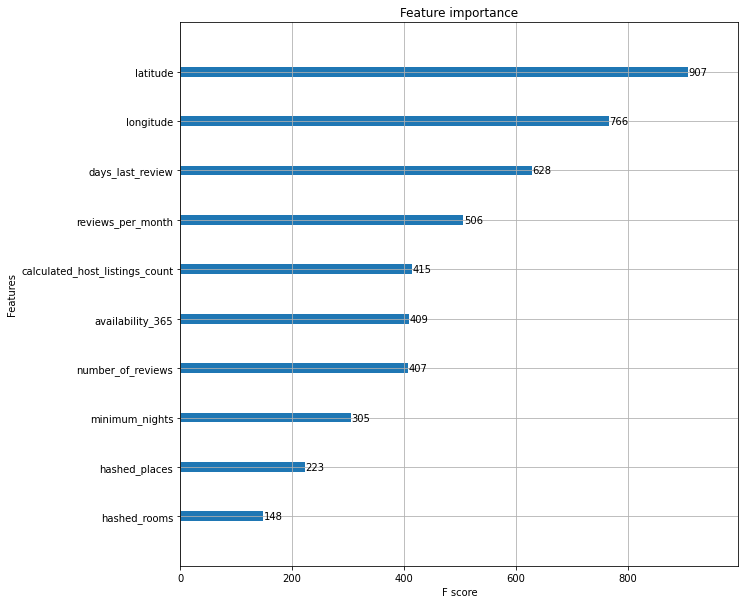

<Figure size 1152x864 with 0 Axes>

In [115]:
xgb.plot_importance(xgb_reg)
plt.figure(figsize = (16, 12))
plt.show()

In [116]:
xgb_regressor=XGBRegressor()


parameters = {
                 'learning_rate': [0.1, 0.3],
                 'max_depth': [4, 6, 8],
                 'n_estimators': [100,200]
             }

XGB_hyper_params = GridSearchCV(estimator=xgb_regressor, param_grid=parameters, n_jobs=-1, cv=5)

In [118]:
XGB_hyper_params.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [119]:
XGB_hyper_params.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

In [120]:
final_xgb = XGBRegressor(learning_rate = 0.1, max_depth = 8, n_estimators = 200)

In [221]:
final_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [222]:
final_y_pred = final_xgb.predict(X_test)


In [223]:
print('Target matric of xgboost model is: {0:0.4f} '.format(mean_squared_error(y_test, final_y_pred,squared=False)))

Target matric of xgboost model is: 36.7057 


In [126]:
from lightgbm import LGBMRegressor as lgb


In [127]:
lgb_model=lgb()


parameters = {
                 'learning_rate': [0.1, 0.3],
                 'max_depth': [4, 6, 8],
                 'n_estimators': [200,300]
             }

lgb_hyper_params = GridSearchCV(estimator=lgb_model, param_grid=parameters, n_jobs=-1, cv=5)

In [128]:
lgb_hyper_params.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [4, 6, 8],
                         'n_estimators': [200, 300]})

In [129]:
lgb_hyper_params.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}

In [224]:
lgb_model=lgb(max_depth = 8, n_estimators = 300)

In [225]:
lgb_model.fit(X_train,y_train)

LGBMRegressor(max_depth=8, n_estimators=300)

In [226]:
lgb_y_pred = lgb_model.predict(X_test)

In [227]:
print('Target matric of base lgb model is: {0:0.4f} '.format(mean_squared_error(y_test, lgb_y_pred,squared=False)))

Target matric of base lgb model is: 36.2424 


In [141]:
ensemble_pred = 0.5*lgb_y_pred + 0.5*final_y_pred

In [142]:
print('Target matric of base ensemble model is: {0:0.4f} '.format(mean_squared_error(y_test, ensemble_pred,squared=False)))

Target matric of base ensemble model is: 35.4739 


# notes 
delete highly correlated feature from our dataset increased a lit bit light gbm model

In [228]:
new_X_train = X_train.drop('reviews_per_month',axis=1)
new_X_test = X_test.drop('reviews_per_month',axis=1)

In [229]:
lgb_model_1 = lgb(max_depth = 8, n_estimators = 300)
final_xgb_1 = XGBRegressor(learning_rate = 0.1, max_depth = 8, n_estimators = 200)

In [230]:
lgb_model_1.fit(new_X_train,y_train)

LGBMRegressor(max_depth=8, n_estimators=300)

In [231]:
final_xgb_1.fit(new_X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [232]:
lgb_y_pred_1 = lgb_model_1.predict(new_X_test)

In [233]:
final_y_pred_1 = final_xgb_1.predict(new_X_test)


In [234]:
print('Target matric of base lgb model is: {0:0.4f} '.format(mean_squared_error(y_test, lgb_y_pred_1,squared=False)))

Target matric of base lgb model is: 36.1601 


In [235]:
print('Target matric of xgboost model is: {0:0.4f} '.format(mean_squared_error(y_test, final_y_pred_1,squared=False)))

Target matric of xgboost model is: 35.9839 


In [155]:
ensemble_pred_1 = 0.75*lgb_y_pred + 0.25*final_y_pred

In [156]:
print('Target matric of base ensemble model is: {0:0.4f} '.format(mean_squared_error(y_test, ensemble_pred,squared=False)))

Target matric of base ensemble model is: 35.4739 


### preprocessing test data

In [167]:
test = pd.read_csv('flat_info_test.csv')

In [168]:
test = test.drop(['id','name','host_id','host_name'],axis=1)

In [169]:
hash_space=3000
test['hashed_places'] = pd.Series(hash(place)%hash_space for place in test.neighbourhood)

In [170]:
hash_space=80
test['hashed_rooms'] = pd.Series(hash(place)%hash_space for place in test.room_type)

In [172]:
test = test.drop(['neighbourhood','room_type'],axis=1)

In [173]:
test

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,hashed_places,hashed_rooms
0,41.41363,2.20724,32,0,NaN,NaN,29,364,2139,60
1,41.37290,2.16580,32,0,NaN,NaN,39,181,2740,60
2,41.38216,2.15141,4,0,NaN,NaN,1,0,2286,62
3,41.38441,2.18361,4,12,2021-01-11,0.89,12,40,373,60
4,41.40360,2.17037,3,167,2020-11-19,2.09,4,326,473,60
...,...,...,...,...,...,...,...,...,...,...
1843,41.40798,2.18416,2,66,2020-03-01,1.45,3,281,2547,62
1844,41.39798,2.20426,1,158,2020-01-03,1.59,1,131,814,60
1845,41.39926,2.16205,1,534,2021-01-29,5.43,1,339,2965,60
1846,41.37301,2.16530,2,20,2020-02-18,1.10,2,0,2740,62


In [175]:
test.last_review = pd.to_datetime(test.last_review)

In [177]:
new_days_1=[]
for last in test.last_review:
    try:
        new_days_1.append((now-last.date()).days)
    except:
        new_days_1.append(np.nan)

In [178]:
test['days_last_review'] = pd.Series(new_days_1)

In [179]:
test = test.drop('last_review',axis=1)

In [180]:
imputer = KNNImputer(n_neighbors=5)

In [181]:
new_test=imputer.fit_transform(test)

In [183]:
new_test = pd.DataFrame(data=new_test,columns=['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','hashed_places','hashed_rooms','days_last_review'])

In [184]:
new_test

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,hashed_places,hashed_rooms,days_last_review
0,41.41363,2.20724,32.0,0.0,0.194,29.0,364.0,2139.0,60.0,515.8
1,41.37290,2.16580,32.0,0.0,0.198,39.0,181.0,2740.0,60.0,603.2
2,41.38216,2.15141,4.0,0.0,0.060,1.0,0.0,2286.0,62.0,1228.4
3,41.38441,2.18361,4.0,12.0,0.890,12.0,40.0,373.0,60.0,162.0
4,41.40360,2.17037,3.0,167.0,2.090,4.0,326.0,473.0,60.0,215.0
...,...,...,...,...,...,...,...,...,...,...
1843,41.40798,2.18416,2.0,66.0,1.450,3.0,281.0,2547.0,62.0,478.0
1844,41.39798,2.20426,1.0,158.0,1.590,1.0,131.0,814.0,60.0,536.0
1845,41.39926,2.16205,1.0,534.0,5.430,1.0,339.0,2965.0,60.0,144.0
1846,41.37301,2.16530,2.0,20.0,1.100,2.0,0.0,2740.0,62.0,490.0


In [185]:
new_test = new_test.drop('reviews_per_month',axis=1)

In [186]:
final_lgb_pred = lgb_model_1.predict(new_test)

In [187]:
final_xgb_pred = final_xgb_1.predict(new_test)


In [188]:
final_ensemble_pred = 0.75*final_lgb_pred + 0.25*final_xgb_pred

In [191]:
predictions=pd.Series(data=final_ensemble_pred)

In [192]:
predictions.to_csv("Kyrylo_Yemets_predictions.csv",index=False)